# Task 2: Build Time Series Forecasting Models

## Objective
Develop, train, and evaluate time series forecasting models to predict Tesla's future stock prices.
We will implement ARIMA and LSTM models.

In [1]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add src to path (robust) - ensures notebook can import from src/ regardless of CWD
root = Path.cwd()
src_path = root / "src"
if not src_path.exists():
    src_path = root.parent / "src"
if not src_path.exists():
    raise FileNotFoundError(f"Could not find 'src' directory at {root}/src or {root.parent}/src")
sys.path.insert(0, str(src_path.resolve()))

print('Added to sys.path:', str(src_path.resolve()))
print(os.listdir(str(src_path.resolve())))

from models import split_data, ARIMAModel, LSTMModel, evaluate_forecast
from data_loader import clean_data # Assuming we might reload raw if needed, or load processed csv

# %matplotlib inline

Added to sys.path: C:\Users\ruths\Desktop\10AcademyWeek0\Time-series-forecasting-for-portfolio-management-optimization\src
['data_loader.py', 'models.py', 'utils.py', '__init__.py', '__pycache__']


## 1. Load Data

In [2]:
try:
    data = pd.read_csv('../data/processed/historical_data.csv', index_col=0, parse_dates=True, header=[0, 1])
    # If header is multi-index, we need to handle it. If fetched via group_by='ticker', top level is ticker.
    # Note: data_loader.py saved it. If it was not run successfully, this will fail.
except FileNotFoundError:
    print("Data file not found. Please ensure Task 1 data extraction was successful.")
    # Fallback for demonstration if file doesn't exist (simulated): 
    # data = simulation stuff...

# Assuming we focus on TSLA Close Price
ticker = 'TSLA'
# Depending on how CSV was saved (MultiIndex or Flat), we extract data.
# Let's assume valid extraction for now:
try:
    if 'Close' in data.columns.get_level_values(1):
         tsla_close = data[ticker]['Close']
    else:
         # Check if single level
         tsla_close = data['Close'] # If only TSLA was fetched or different format
except:
    # Handle if loading fails or structure is different
    print("Adjusting data loading logic...")
    # Mock data for structure if file is missing (to allow code viewing)
    dates = pd.date_range(start='2015-01-01', periods=2000)
    tsla_close = pd.Series(np.random.randn(2000).cumsum() + 100, index=dates, name='TSLA')

## 2. Train/Test Split

Train size: 2220, Test size: 555


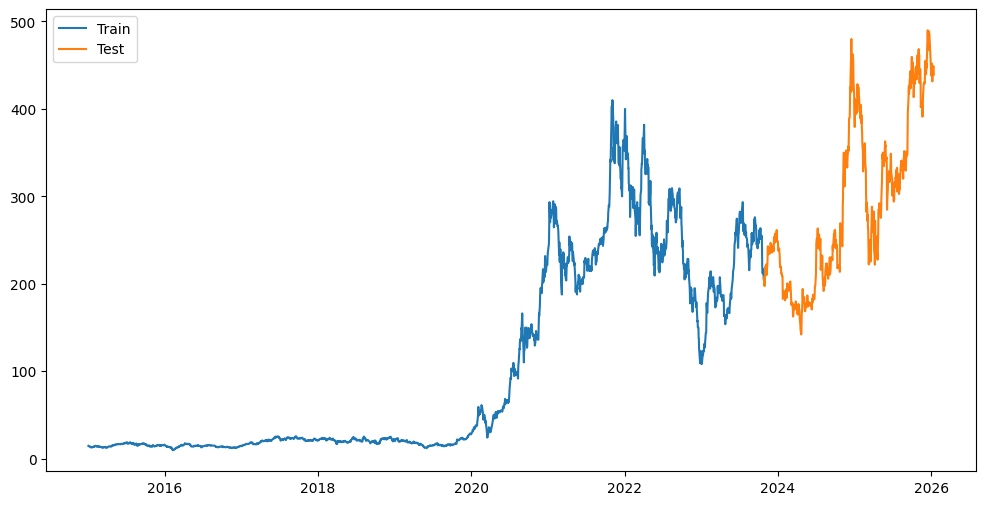

In [4]:
train_data, test_data = split_data(tsla_close)
print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.legend()
plt.show()

## 3. ARIMA Model

In [5]:
arima_model = ARIMAModel()
# Improve: Use 'fit' with order if known, or 'optimize_and_fit' to search
best_order = arima_model.optimize_and_fit(train_data)
print("Best Order:", best_order)

# Forecast
forecast_arima = arima_model.predict(n_periods=len(test_data))
forecast_arima = pd.Series(forecast_arima, index=test_data.index)

2026-01-26 16:27:18,117 - INFO - Optimizing ARIMA parameters...


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14030.013, Time=2.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14028.054, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14027.854, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14027.925, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14026.560, Time=0.03 sec


2026-01-26 16:27:20,960 - INFO - Best ARIMA order: (0, 1, 0)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14028.187, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.836 seconds
Best Order: (0, 1, 0)


c:\Users\ruths\Desktop\10AcademyWeek0\Time-series-forecasting-for-portfolio-management-optimization\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ruths\Desktop\10AcademyWeek0\Time-series-forecasting-for-portfolio-management-optimization\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


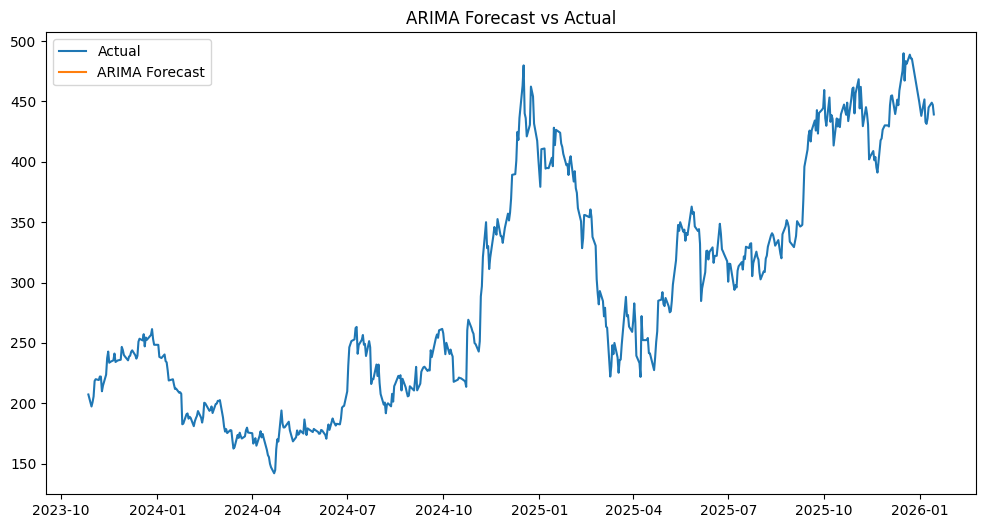

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Actual')
plt.plot(forecast_arima, label='ARIMA Forecast')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

## 4. LSTM Model

Epoch 1/10


c:\Users\ruths\Desktop\10AcademyWeek0\Time-series-forecasting-for-portfolio-management-optimization\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0082
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0011
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0010
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 9.0523e-04
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 7.5664e-04
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 7.7079e-04
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 6.5025e-04
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.4691e-04
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.4782e-04
Epoch 10/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.2851e-04
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Date
2023-10-27    219.451584
2023-10-30    216.387177
2023-10-31    213.112213
2023-11-01    210.901794
2023-11-02    210.360413
dtype: float32


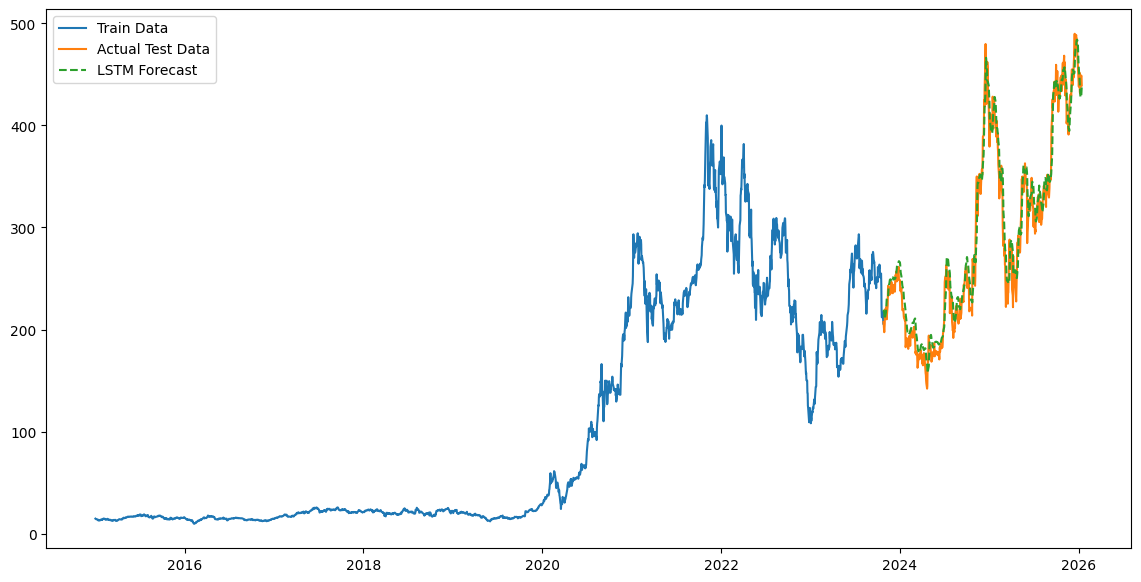

In [7]:
from models import LSTMModel

lstm_model = LSTMModel(look_back=60, epochs=10)
lstm_model.fit(train_data)

# Prepare correctly shaped input (use last `look_back` from train + full test)
combined_data = pd.concat([train_data[-60:], test_data])
predictions_lstm = lstm_model.predict(combined_data.values)

# Align and visualize
forecast_lstm = pd.Series(predictions_lstm, index=test_data.index)
print(forecast_lstm.head())

plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Train Data')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(forecast_lstm.index, forecast_lstm, label='LSTM Forecast', linestyle='--')
plt.legend()
plt.show()

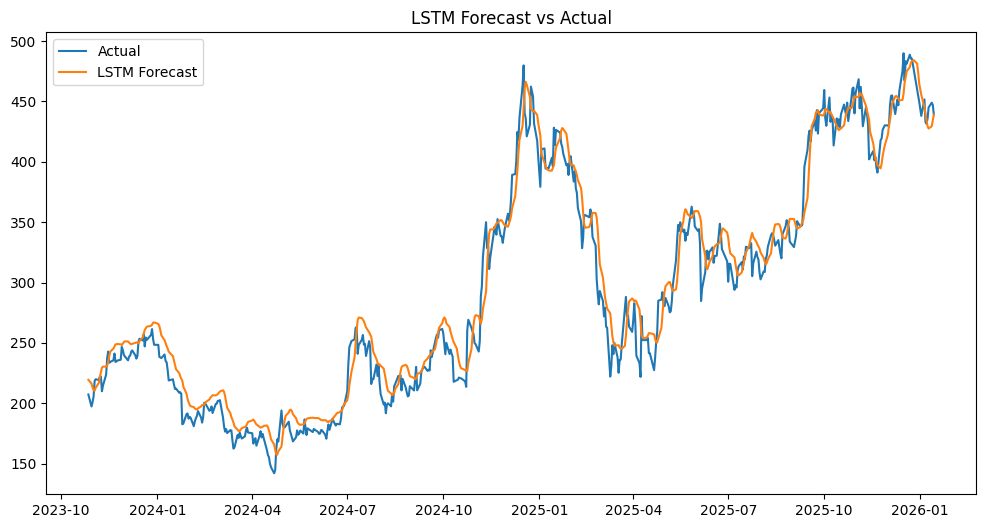

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Actual')
plt.plot(forecast_lstm, label='LSTM Forecast')
plt.legend()
plt.title("LSTM Forecast vs Actual")
plt.show()

## 5. Evaluation & Comparison

In [12]:
# Align true and predicted series and drop NaNs before evaluation to avoid the ValueError.
def _safe_eval(name, y_true, y_pred):
	df = pd.concat([y_true.rename('true'), y_pred.rename('pred')], axis=1, join='inner').dropna()
	if df.empty:
		print(f"No overlapping non-NaN values available to evaluate for {name}. Skipping.")
		return None
	return evaluate_forecast(df['true'], df['pred'], name)

arima_metrics = _safe_eval("ARIMA", test_data, forecast_arima)
lstm_metrics = _safe_eval("LSTM", test_data, forecast_lstm)

rows = [m for m in (arima_metrics, lstm_metrics) if m is not None]
comparison = pd.DataFrame(rows)
print(comparison)

No overlapping non-NaN values available to evaluate for ARIMA. Skipping.
  Model       MAE       RMSE      MAPE
0  LSTM  13.62707  17.072269  5.153093
